### Mounting local folder with data files via DataBricks CLI interface
run in cmd prompt
- databricks configure --token
- databricks fs cp "C:\Users\marty\OneDrive - The George Washington University\Documents\CSCI 4443\Project\data" dbfs:/mnt/data --recursive
  - change <C:\Users\marty\OneDrive - The George Washington University\Documents\CSCI 4443\Project> to the path leading to wherever you have the files saved in a folder 'data'

Then you can read file using this command (instert file name for <file.csv>)
- df = spark.read.csv("dbfs:/mnt/local/<file.csv>", header=True, inferSchema=True)

In [0]:
# loading dependencies
from IPython.display import display
from pyspark.sql.functions import explode, split, count, regexp_replace
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import regexp_replace, trim

### Loading in datasets for each queried role

In [0]:
# loading 3 tech job datasets into spark dataframes
data_analyst = spark.read.csv("dbfs:/mnt/data/clean_data_data_analyst.csv", header=True, inferSchema=True)
software_engineer = spark.read.csv("dbfs:/mnt/data/clean_data_software_engineer.csv", header=True, inferSchema=True)
software_programmer = spark.read.csv("dbfs:/mnt/data/clean_data_software_programmer.csv", header=True, inferSchema=True)

# combining all datasets into one
total_data = data_analyst.union(software_engineer).union(software_programmer)

### Defining functions used to generate analytics

In [0]:
def getCountsProgLang(dataframe):
    df_prog = dataframe.withColumn("Programming Languages", split(dataframe["Programming Languages"], ",\s*").cast("array<string>"))
    
    # explode the programming languages column
    df_exploded = df_prog.select(explode("Programming Languages").alias("language"))

    # group by the language and count occurrences
    df_counts = df_exploded.withColumn("language", regexp_replace(df_exploded["language"], "[\[\]']", ""))
    df_counts = df_counts.groupBy("language").agg(count("*").alias("count"))

    return(df_counts)

def getCountsDatab(dataframe):
    # explode the databases column to convert the array of strings to individual rows
    df_db = dataframe.select(explode(split(col("Databases"), ",")).alias("Database"))

    # group by database name and count the occurrences
    df_db = df_db.withColumn("Database", regexp_replace(df_db["Database"], "[\[\]']", ""))
    df_db_counts = df_db.groupBy("Database").count().orderBy("count", ascending=False)
    
    return(df_db_counts)

def getCountsCloudDist(dataframe):
    # explode the Cloud and or Distributed- column to convert the array of strings to individual rows
    df_cd = dataframe.select(explode(split(col("Cloud and or Distributed Computing Platforms"), ",")).alias("CloudDist"))

    # group by CloudDist name and count the occurrences
    df_cd = df_cd.withColumn("CloudDist", regexp_replace(df_cd["CloudDist"], "[\[\]']", ""))
    df_cd_counts = df_cd.groupBy("CloudDist").count().orderBy("count", ascending=False)
    
    return(df_cd_counts)

def getCountsBigrams(dataframe):
    # explode the bigrams column to convert the array of strings to individual rows
    df_big = dataframe.select(explode(split(col("bigrams"), ",")).alias("big"))

    # group by big name and count the occurrences
    df_big = df_big.withColumn("big", regexp_replace(df_big["big"], r"[\[\]\'+-]", ""))
    df_big_counts = df_big.groupBy("big").count().filter("big != ''").orderBy("count", ascending=False)
    
    return(df_big_counts)


In [0]:
def PieChart(dataframe, object_name, query_name):
    # dataframe is PySpark DataFrame with two columns - "objects" and "count"
    counts = dataframe.groupBy(object_name).agg(F.sum("count").alias("count"))

    # Calculate the percentage of each 'object' and filter those below 2%
    total_count = counts.agg(F.sum("count")).collect()[0][0]
    counts = counts.withColumn("percentage", F.col("count") / total_count)
    other_count = counts.filter(F.col("percentage") < 0.03).agg(F.sum("count")).collect()[0][0]
    other_pct = (other_count / total_count) * 100
    filtered_counts = counts.filter(F.col("percentage") >= 0.03)

    # Group 'objects' below 2% into "Other" category
    other = counts.filter(F.col("percentage") < 0.03)
    other = other.withColumn(object_name, F.lit("Other")).groupBy(object_name).agg(F.sum("count").alias("count")).withColumn("percentage", F.col("count") / total_count)
    filtered_counts = filtered_counts.union(other)

    # Convert the PySpark DataFrame to a Pandas DataFrame for plotting
    counts_pd = filtered_counts.toPandas()

    # Set the labels for the pie chart, including the "Other" category
    labels = counts_pd[object_name].tolist()
    labels = [label if counts_pd.loc[i, "percentage"] >= 0.03 else "Other" for i, label in enumerate(labels)]

    # Set the counts and colors for the pie chart
    counts = counts_pd["count"].tolist()
    colors = plt.cm.Set3.colors[:len(counts)]

    # plotting the pie chart
    plt.pie(counts, labels=labels, colors=colors, autopct="%1.1f%%")
    plt.axis("equal")
    plt.title("{} Distribution - {}".format(object_name, query_name))

    # Create a custom legend for the "Other" category
    plt.legend(handles=[plt.Rectangle((0,0),1,1,fc="gray", edgecolor='none')], labels=["Other ({:.1f}%)".format(other_pct)], loc="center left", bbox_to_anchor=(1, 0.5))

    return(plt.show())

# function to generate top bigram chart for dataset
def getBigramChart(dataframe):
    # Convert the PySpark DataFrame to a Pandas DataFrame for plotting
    top bigrams = dataframe.groupBy("big").count().filter("big != ''").orderBy("count", ascending=False).limit(15)
    top_bigrams_pd = top_bigrams.toPandas()

    # Plot the bar graph
    plt.barh(top_bigrams_pd["big"], top_bigrams_pd["count"])
    plt.gca().invert_yaxis()
    plt.xlabel("Count")
    plt.ylabel("Bigrams")
    plt.title("Top 15 Bigrams")
    return(plt.show())

### Creating DataFrame for each job role that house counts for specific type of object

In [0]:
# Generating dataframes for counts of specific objects for data analyst role
progl_da = getCountsProgLang(data_analyst)
datab_da = getCountsDatab(data_analyst)
cloudd_da = getCountsCloudDist(data_analyst)
bigr_da = getCountsBigrams(data_analyst)

# Generating dataframes for counts of specific objects for software engineer role
progl_se = getCountsProgLang(software_engineer)
datab_se = getCountsDatab(software_engineer)
cloudd_se = getCountsCloudDist(software_engineer)
bigr_se = getCountsBigrams(software_engineer)

# Generating dataframes for counts of specific objects for software programmer role
progl_sp = getCountsProgLang(software_programmer)
datab_sp = getCountsDatab(software_programmer)
cloudd_sp = getCountsCloudDist(software_programmer)
bigr_sp = getCountsBigrams(software_programmer)


### Generating Pie Charts for Programming Languages and Software Occurrence in Dataset
- PieChart(dataframe, object_name, query_name) function takes 2nd input to the alias of the column, this will vary based on the type of objects being used to generate the pie chart
    - Programming Lanugages : object_name = 'language'
    - Databases : object_name = 'database'
    - Cloud and or Dist Compute : object_name = 'CloudDist'

- In addition, the dataframe must be generated from the corresponding getCounts___() Function for the object in question

## Data Analyst Role

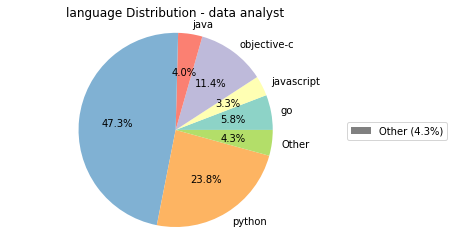

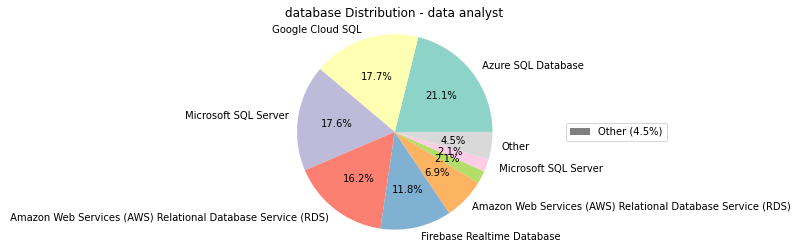

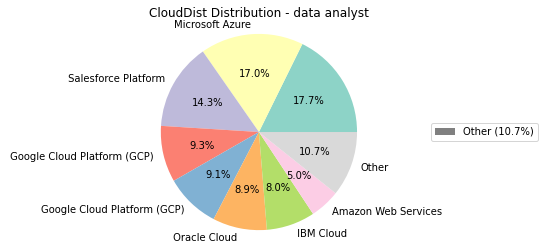

NoneNoneNone

In [0]:
display(PieChart(progl_da, 'language', 'data analyst'), PieChart(datab_da, 'database', 'data analyst'),PieChart(cloudd_da, 'CloudDist', 'data analyst'))

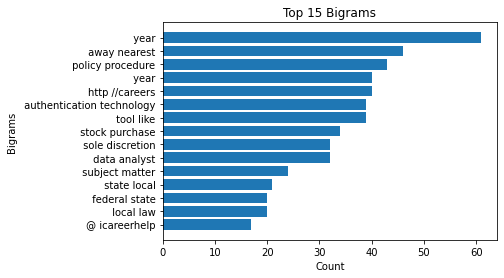

In [0]:
getBigramChart(bigr_da)

## Software Engineer Role

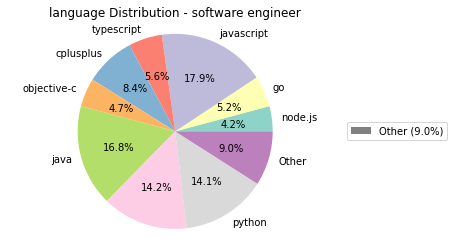

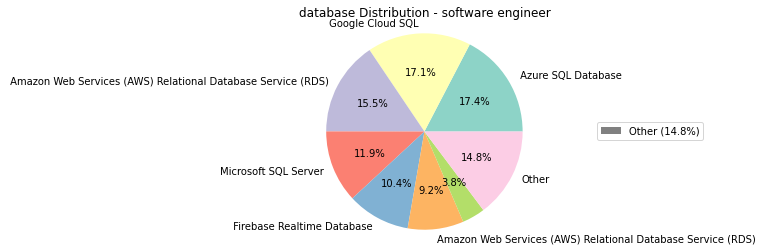

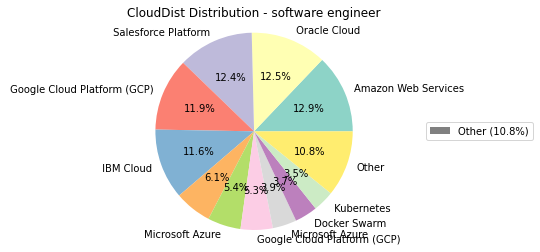

NoneNoneNone

In [0]:
display(PieChart(progl_se, 'language', 'software engineer'), PieChart(datab_se, 'database', 'software engineer'),PieChart(cloudd_se, 'CloudDist', 'software engineer'))

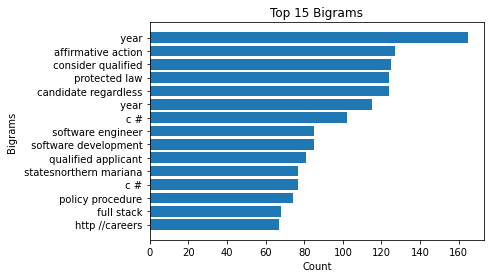

In [0]:
getBigramChart(bigr_se)

## Software Programmer Role

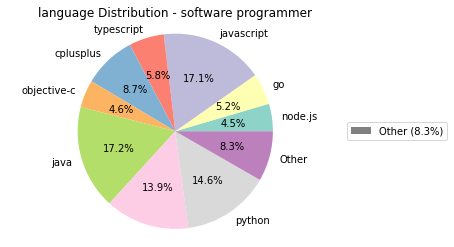

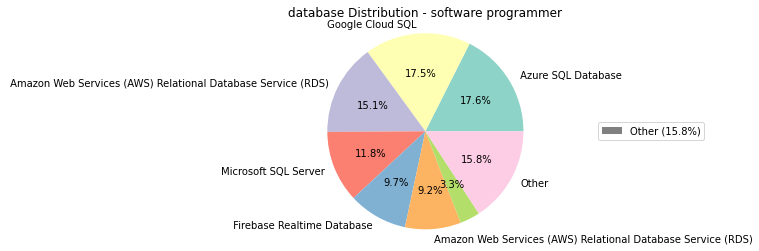

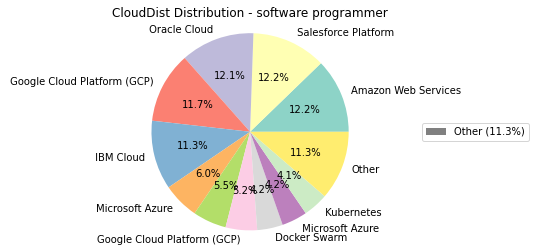

NoneNoneNone

In [0]:
display(PieChart(progl_sp, 'language', 'software programmer'), PieChart(datab_sp, 'database', 'software programmer'),PieChart(cloudd_sp, 'CloudDist', 'software programmer'))

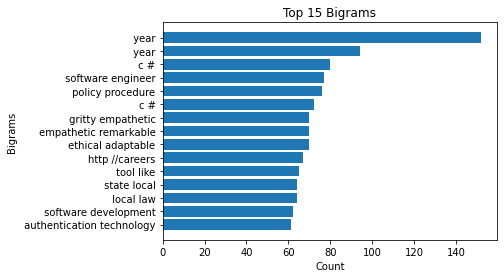

In [0]:
getBigramChart(bigr_sp)